In [88]:
#### ILI-AII-Pneumonia-Weather 2016-2018 LSTM-n -- FORECAST BASED ON n PERIODS

#########################################################
# GENERAL MODEL PARAMETERS
#########################################################

import pandas as pd

# Perform Target Smoothing with Savitsky-Golay
smoothing = 0 # window for the rolling average

### move the rolling average up
predict_days = 7 # 7 ---> (t+7) [THESE ARE PERIODS - CAN BE DAYS OR WEEKS DEPENDING ON THE MODEL]

# specify the number of lag days (t-1), (t-2), ... (t-n_lag)
n_days = 14 # 7 ---> (t+7) [THESE ARE PERIODS - CAN BE DAYS OR WEEKS DEPENDING ON THE MODEL]

# Keep data columns for weather or age groups

#########################################################
# FEATURES
#########################################################

include_weather = True  # U, T 9, 13-30, 18, 21
include_weather_inside_relative_humidity = False
include_weather_ITF = False
include_age_groups = False
include_case_count_year_before = False
include_case_count_diff = 14

include_day_off = True  # Sat + Sun
include_day_off_sat = False
include_day_off_sun = False

include_school_breaks = True
include_holiday = True

outlier_suppress = True  # 2009

include_case_counts = False 

normalize_features = True

# Keep either only aggregate part or daily part or both ...
Aggregate_Part = True
Daily_Part = True

Aggregate_Cases = False  # convert into weekly from daily

substract_seasonal = False # Substract seasonal (seasonal-trend-residual)
split_seasonal_residuals = False 
add_ili_counts = False # Add ILI counts to improve forecasting (pneumonia)

#########################################################
# DATA
#########################################################

#Disease = "Pneumonia"
#Disease = "Acute Intestinal Infections"
Disease = "Influenza Like Ilness"

#########################################################
# ANN PARAMETERS
#########################################################

epochs_number = 500
model_type = 5
ModelNeuronsQty = 15
n_dropout = 0.0

Comment = ""

#########################################################
#  AUTOMATED EXECUTION
#########################################################

experiment_shell_driven = False

try:
    df_experiment = pd.read_csv('experiments.csv', sep=',')
    experiment_shell_driven = True    

except NameError:
    print("File Not Found.")
except Exception, e:
    print("File Not Found.")
        

if experiment_shell_driven == True:
    df_experiment_index = df_experiment.experiment_no == df_experiment[pd.isnull(df_experiment.executed)].experiment_no.min()    

    if df_experiment_index.max() == False:
        raise

    n_days = df_experiment[df_experiment_index ].n_days.max()
    predict_days = df_experiment[df_experiment_index ].n_predict.max()
    ModelNeuronsQty = int(df_experiment[df_experiment_index ].n_neurons.max())
    model_type = int(df_experiment[df_experiment_index ].model_type.max())
    epochs_number = int(df_experiment[df_experiment_index ].n_epochs.max())
    n_dropout = df_experiment[df_experiment_index ].n_dropout.max()
    include_case_count_diff = df_experiment[df_experiment_index ].case_count_diff.max()
        
    


def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    import numpy
    from math import factorial

    try:
        window_size = numpy.abs(numpy.int(window_size))
        order = numpy.abs(numpy.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = numpy.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = numpy.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - numpy.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + numpy.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = numpy.concatenate((firstvals, y, lastvals))
    return numpy.convolve( m[::-1], y, mode='valid')

import numpy
import datetime as dt
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline

File Not Found.


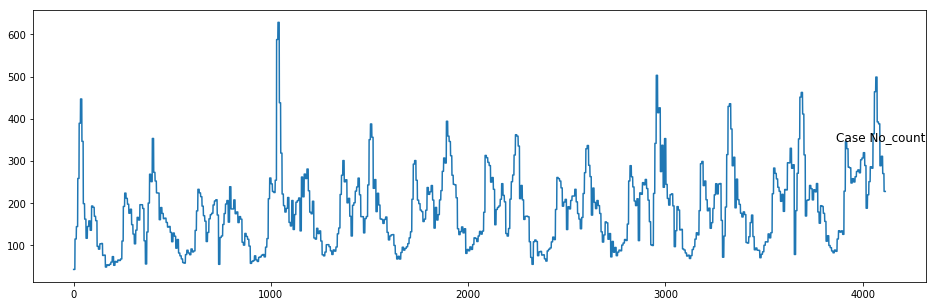

,Case No_count
LT,
2007-01-01,42.142857
2007-01-02,42.142857
2007-01-03,42.142857
2007-01-04,42.142857
2007-01-05,42.142857


In [89]:
# INPUT 2: preprocess-join-agg-oki-counts-and-weather.py
#          agg-oki-counts-and-weather-2012-2016.csv

# load dataset
if Disease == "Pneumonia":
#    agg_dataset = read_csv('agg-pneumonia-counts-and-weather-2013-2016.csv', header=0, index_col=0)
    agg_dataset = read_csv('data_daily_pneumonia.csv', header=0, index_col=0)    
if Disease == "Acute Intestinal Infections":
    agg_dataset = read_csv('agg-oki-counts-and-weather-2012-2016.csv', header=0, index_col=0)
if Disease == "Influenza Like Ilness":
    agg_dataset = read_csv('daily-ili-counts-2007-2018.csv', header=0, index_col=0)

#REARRANGE COLUMNS TO MATCH
#Case No_count	Po_min	Po_max	Po_mean	U_min	U_max	U_mean	T_min	T_max	T_mean	RRRN_sum

#agg_dataset = agg_dataset[["oki-count_RM", "Po_min","Po_max", "Po_mean", "U_min", "U_max", "U_mean", "T_min", "T_max", "T_mean", "RRRN_sum" ]]
agg_dataset = agg_dataset[["Case No_count" ]]
agg_dataset.rename(columns={'Case No_count':'Case No_count'}, inplace=True)

if Disease != "Influenza Like Ilness" and Disease != "Pneumonia":
    case_counts = agg_dataset["Case No_count"].values

    for i in range (0,len(case_counts),7) :
        mean = case_counts[i:i+7].mean() 
        case_counts[i:i+7] = mean

    agg_dataset["Case No_count"] = case_counts

# Supress outliers
if outlier_suppress == True:
    ##agg_dataset.loc[agg_dataset["Case No_count"] >= agg_dataset["Case No_count"].max() *0.8] *= 0.4
    cap = agg_dataset.loc[agg_dataset["Case No_count"] < agg_dataset["Case No_count"].max() *0.6].max() * 1.25
    cap = cap / agg_dataset.loc[agg_dataset["Case No_count"] >= agg_dataset["Case No_count"].max() *0.6].max()
    agg_dataset.loc[agg_dataset["Case No_count"] >= agg_dataset["Case No_count"].max() *0.6] *= cap

values = agg_dataset.values
# specify columns to plot
#groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
groups = [0]
i = 1
# plot each column
pyplot.figure(figsize=(16, 5))
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(agg_dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()


#if Disease != "Influenza Like Ilness":
#    # cut case-based to match weekly data
#    agg_dataset = agg_dataset[(agg_dataset.index < cases_dataset.index.min())]

agg_dataset.head()

In [90]:
#agg_dataset.loc[agg_dataset["Case No_count"] >= agg_dataset["Case No_count"].max() *0.6]

In [91]:
agg_dataset.loc[agg_dataset["Case No_count"] < agg_dataset["Case No_count"].max() *0.6].max() * 1.25

Case No_count    469.464286
dtype: float64

In [92]:
agg_dataset.loc[agg_dataset["Case No_count"] < agg_dataset["Case No_count"].max() *0.8].max() * 1.25


Case No_count    628.571429
dtype: float64

In [93]:
# Outliers ...

agg_dataset.loc[agg_dataset["Case No_count"] >= agg_dataset["Case No_count"].max() *0.8]

,Case No_count
LT,
2009-10-26,587.802517
2009-10-27,587.802517
2009-10-28,587.802517
2009-10-29,587.802517
2009-10-30,587.802517
2009-10-31,587.802517
2009-11-01,587.802517
2009-11-02,628.571429
2009-11-03,628.571429


Case No_count    42.142857
Name: 2007-01-01, dtype: float64
Case No_count    198.285714
Name: 2007-02-20, dtype: float64


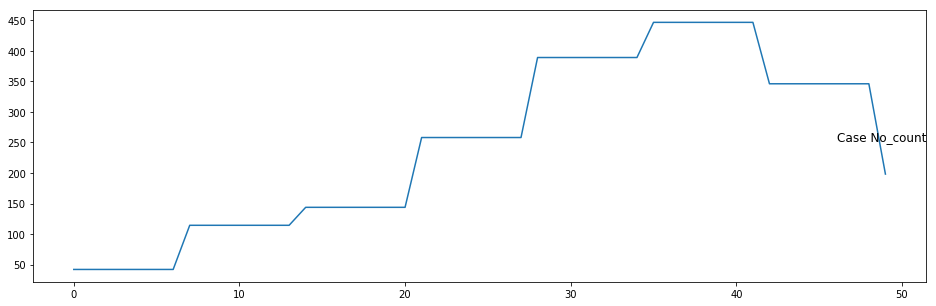

In [94]:
i1 = 0
i2 = 50
print(agg_dataset.iloc[i1])
print(agg_dataset.iloc[i2])
pyplot.figure(figsize=(16, 5))
pyplot.plot(values[i1:i2, 0])
pyplot.title(agg_dataset.columns[0], y=0.5, loc='right')
pyplot.show()



In [95]:
# MERGE TWO DATASETS

import pandas as pd

if Disease != "Influenza Like Ilness" and Disease != "Pneumonia":
    dataset = pd.concat([agg_dataset,cases_dataset])
else:
    dataset = agg_dataset

cols = list(dataset)
cols.insert(0, cols.pop(cols.index('Case No_count')))
#dataset = dataset.ix[:, cols]
dataset = dataset.loc[:, cols]


# Perform Target Smoothing with RA
# INPUT: rolling_window # window for the rolling average

from matplotlib import pyplot
%matplotlib inline

# prepare the target column

if smoothing > 0 :
#    dataset['Case No_RM'] = dataset['Case No_count'].rolling(window=rolling_window,min_periods=1).mean()
    counts = dataset['Case No_count'].values
    dataset['Case No_RM'] = savitzky_golay(counts,smoothing,2)
else:
    dataset['Case No_RM'] = dataset['Case No_count']
    dataset['Case_Actuals'] = dataset['Case No_count']
    

# Replace weather part of the dataset w/ weather
    
weather_dataset = pd.read_csv('weather-09-1330-18.csv', index_col=0, sep=',')

weather_dataset.fillna(0, inplace=True)
dataset = dataset.join(weather_dataset)

In [96]:
dataset.tail(10)

,Case No_count,Case No_RM,Case_Actuals,ITF09,ITF1330,ITF18,ITF21,RH09,RH1330,RH18,...,RHTR18,RHTR21,T09,T1330,T18,T21,U09,U1330,U18,U21
LT,,,,,,,,,,,,,,,,,,,,,
2018-03-30,269.714286,269.714286,269.714286,81.953124,77.110096,70.565827,69.085228,13.984375,12.370032,10.188609,...,23.000000,21.806948,6.0,11.5,9.0,4.0,38.0,24.0,23.0,28.0
2018-03-31,269.714286,269.714286,269.714286,69.395425,66.420033,72.898677,76.989859,9.395425,6.420033,10.966226,...,26.321837,29.595143,-1.0,5.5,7.0,4.0,40.0,18.0,28.0,38.0
2018-04-01,269.714286,269.714286,269.714286,92.715753,93.529100,93.368151,93.330766,22.715753,23.529100,23.368151,...,44.000000,56.000000,7.0,12.5,12.0,8.0,58.0,43.0,44.0,56.0
2018-04-02,227.285714,227.285714,227.285714,72.016857,70.753120,68.524904,67.775082,10.672286,10.251040,8.524904,...,20.462022,18.662250,6.0,6.5,3.0,0.0,29.0,27.0,28.0,31.0
2018-04-03,227.285714,227.285714,227.285714,66.341912,64.568761,64.227941,63.846982,6.341912,4.568761,4.227941,...,10.148175,9.233773,-1.0,2.0,-1.0,-4.0,27.0,16.0,18.0,20.0
2018-04-04,227.285714,227.285714,227.285714,64.198297,64.126441,63.762136,65.001076,4.198297,4.126441,3.762136,...,9.030121,12.003904,-6.0,-0.5,0.0,-4.0,25.0,17.0,15.0,26.0
2018-04-05,227.285714,227.285714,227.285714,65.056866,64.128183,64.262452,65.770473,5.056866,4.128183,4.262452,...,10.231011,13.850659,-2.0,2.5,3.0,-4.0,23.0,14.0,14.0,30.0
2018-04-06,227.285714,227.285714,227.285714,65.056866,66.339710,67.002600,69.029127,5.056866,6.339710,7.002600,...,16.808089,21.672290,-2.0,2.5,3.0,0.0,23.0,21.5,23.0,36.0
2018-04-07,227.285714,227.285714,227.285714,69.279937,69.590517,79.349014,78.756128,9.279937,9.590517,13.116338,...,31.482675,31.008314,0.0,3.0,1.0,-1.0,37.0,31.5,49.0,55.0


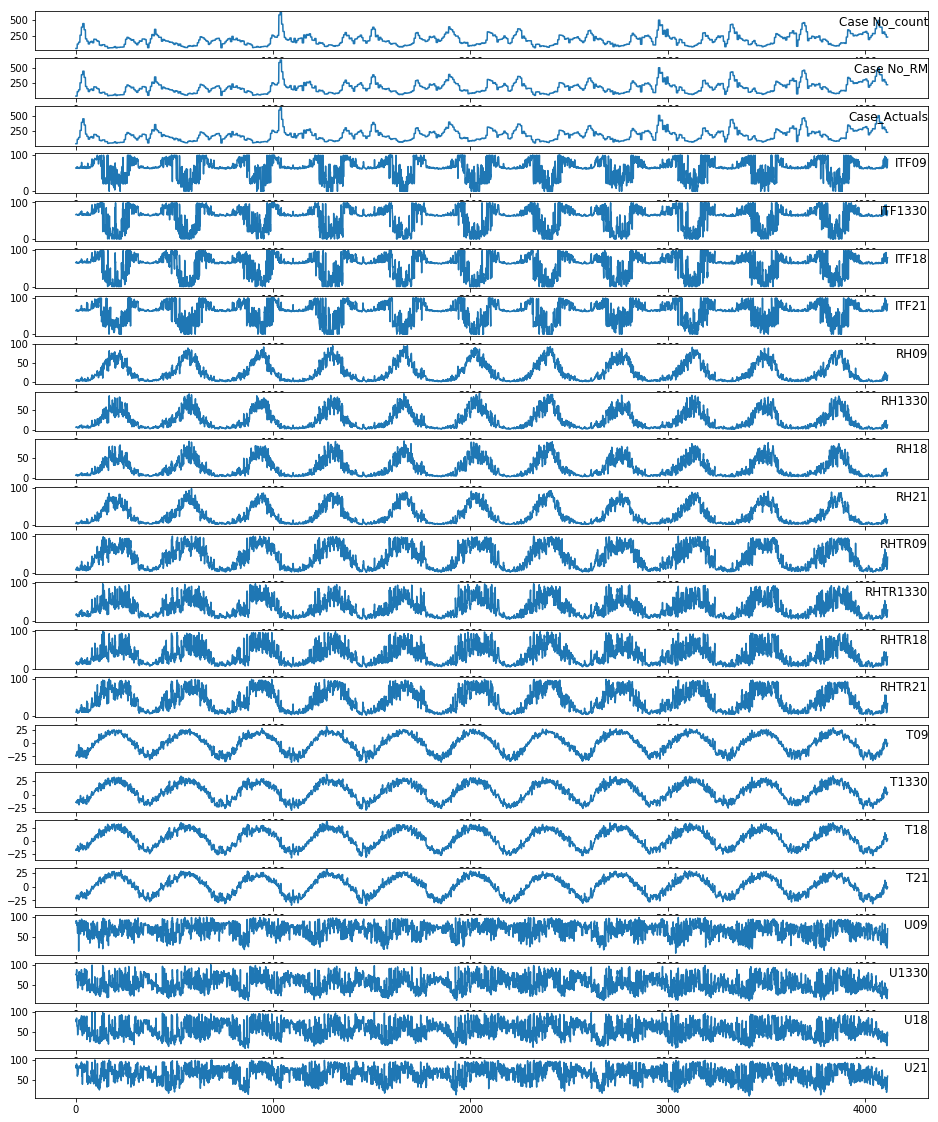

In [97]:
values = dataset.values

i = 1
# plot each column
pyplot.figure(figsize=(16, 20))
for group in range(0,len(dataset.columns)):
    pyplot.subplot(len(dataset.columns), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [98]:
dataset.corr()

,Case No_count,Case No_RM,Case_Actuals,ITF09,ITF1330,ITF18,ITF21,RH09,RH1330,RH18,...,RHTR18,RHTR21,T09,T1330,T18,T21,U09,U1330,U18,U21
Case No_count,1.000000,1.000000,1.000000,0.390060,0.468802,0.481477,0.434482,-0.615774,-0.589578,-0.581195,...,-0.455596,-0.521885,-0.566961,-0.547819,-0.547396,-0.558815,-0.135361,-0.149172,-0.085938,-0.191285
Case No_RM,1.000000,1.000000,1.000000,0.390060,0.468802,0.481477,0.434482,-0.615774,-0.589578,-0.581195,...,-0.455596,-0.521885,-0.566961,-0.547819,-0.547396,-0.558815,-0.135361,-0.149172,-0.085938,-0.191285
Case_Actuals,1.000000,1.000000,1.000000,0.390060,0.468802,0.481477,0.434482,-0.615774,-0.589578,-0.581195,...,-0.455596,-0.521885,-0.566961,-0.547819,-0.547396,-0.558815,-0.135361,-0.149172,-0.085938,-0.191285
ITF09,0.390060,0.390060,0.390060,1.000000,0.839510,0.795825,0.789268,-0.627399,-0.592029,-0.580565,...,-0.371988,-0.398704,-0.361249,-0.352221,-0.347796,-0.356925,-0.301965,-0.295796,-0.254999,-0.333577
ITF1330,0.468802,0.468802,0.468802,0.839510,1.000000,0.925174,0.826377,-0.710834,-0.656676,-0.645304,...,-0.403218,-0.458462,-0.485988,-0.485529,-0.481069,-0.485416,-0.220371,-0.210501,-0.165746,-0.270118
ITF18,0.481477,0.481477,0.481477,0.795825,0.925174,1.000000,0.851046,-0.711570,-0.661337,-0.657204,...,-0.417529,-0.463741,-0.489473,-0.487124,-0.486084,-0.491763,-0.223258,-0.217443,-0.173545,-0.265372
ITF21,0.434482,0.434482,0.434482,0.789268,0.826377,0.851046,1.000000,-0.652857,-0.618308,-0.614285,...,-0.397676,-0.443905,-0.413007,-0.405730,-0.402630,-0.412142,-0.270767,-0.268356,-0.224860,-0.319556
RH09,-0.615774,-0.615774,-0.615774,-0.627399,-0.710834,-0.711570,-0.652857,1.000000,0.963839,0.948532,...,0.806804,0.873448,0.873798,0.859492,0.855459,0.868950,0.327954,0.230479,0.150484,0.321971
RH1330,-0.589578,-0.589578,-0.589578,-0.592029,-0.656676,-0.661337,-0.618308,0.963839,1.000000,0.977223,...,0.873138,0.900524,0.829182,0.805126,0.804699,0.825933,0.378240,0.357321,0.263457,0.407613
RH18,-0.581195,-0.581195,-0.581195,-0.580565,-0.645304,-0.657204,-0.614285,0.948532,0.977223,1.000000,...,0.905384,0.912202,0.822566,0.801300,0.793850,0.818684,0.354584,0.329904,0.309294,0.435656


In [99]:
# Add ILI counts to Pneumonia set

if Disease == "Pneumonia":

    ili_set = read_csv('agg-ili-counts-and-weather-2007-2018.csv', header=0, index_col=0)
    ili_set['ILI_count'] = ili_set['oki-count_RM']
    dataset = dataset.join(ili_set['ILI_count'])
    dataset = dataset[dataset.index <= max(ili_set.index)]
else:
    dataset['ILI_count'] = 0

In [100]:
epi_calendar = read_csv('epi_calendar.csv', header=0, index_col=0)
epi_calendar['epi_year_week'] = epi_calendar.index
epi_calendar.set_index('date.1',inplace=True)

#JOIN DATASETS

merged = dataset.join(epi_calendar)

In [101]:
# ADD THRESHOLDS ....

epi_thresholds = read_csv('thresholds.csv', header=0, index_col=0)

merged = merged.join(epi_thresholds)
merged.drop(['act_count','date_isoweek','threshold_rel','countrel_rel'], axis=1, inplace=True)


In [102]:
merged

,Case No_count,Case No_RM,Case_Actuals,ITF09,ITF1330,ITF18,ITF21,RH09,RH1330,RH18,...,iso_week,epi_week,epi_year,day_off,break_day,holiday,day_off_sat,day_off_sun,epi_year_week,threshold_abs
2007-01-01,42.142857,42.142857,42.142857,63.743566,66.755194,65.682371,64.552475,3.743566,6.755194,5.682371,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-02,42.142857,42.142857,42.142857,64.007817,67.319614,66.451333,65.072999,4.007817,7.319614,6.451333,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-03,42.142857,42.142857,42.142857,63.901543,67.426635,65.827562,65.228237,3.901543,7.426635,5.827562,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-04,42.142857,42.142857,42.142857,65.578179,67.993283,67.434418,66.587478,5.578179,7.993283,7.434418,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-05,42.142857,42.142857,42.142857,64.529731,67.458437,67.825828,67.699854,4.529731,7.458437,7.825828,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-06,42.142857,42.142857,42.142857,65.943873,66.649538,65.126256,64.385285,5.943873,6.649538,5.126256,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-07,42.142857,42.142857,42.142857,63.955950,66.787715,64.938871,64.879905,3.955950,6.787715,4.938871,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-08,114.428571,114.428571,114.428571,66.794052,66.411380,64.975851,63.922127,6.794052,6.411380,4.975851,...,2.0,2.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-02,NaN
2007-01-09,114.428571,114.428571,114.428571,63.139613,64.910732,64.261778,63.951973,3.139613,4.910732,4.261778,...,2.0,2.0,2007.0,0.0,0.0,0.0,0.0,0.0,2007-02,NaN
2007-01-10,114.428571,114.428571,114.428571,65.209378,65.363858,65.572459,64.651748,5.209378,5.363858,5.572459,...,2.0,2.0,2007.0,0.0,0.0,0.0,0.0,0.0,2007-02,NaN


2007.0
2008.0
2009.0
2010.0
2011.0
2012.0
2013.0
2014.0
2015.0
2016.0
2017.0
2018.0
nan


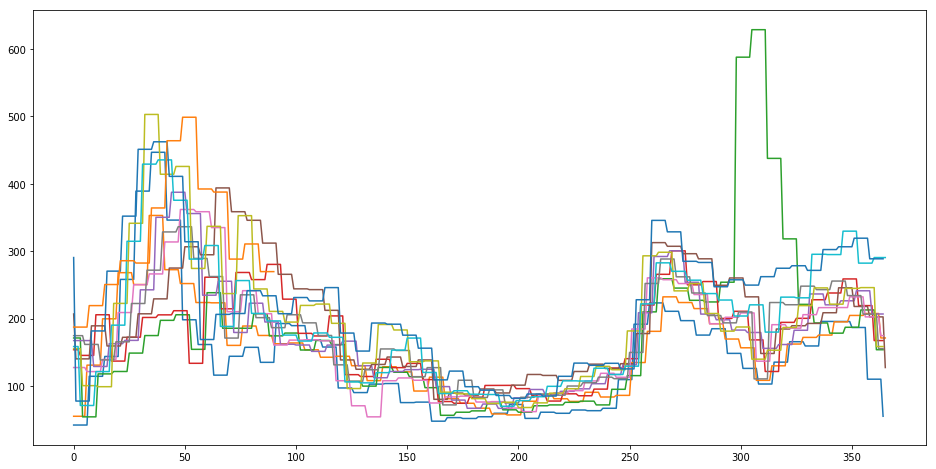

2007.0
2008.0
2009.0
2010.0
2011.0
2012.0
2013.0
2014.0
2015.0
2016.0
2017.0
2018.0


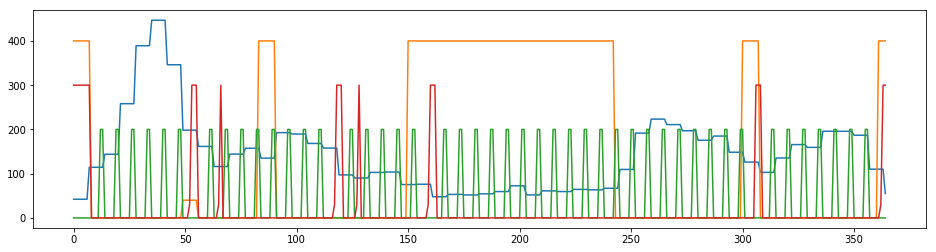

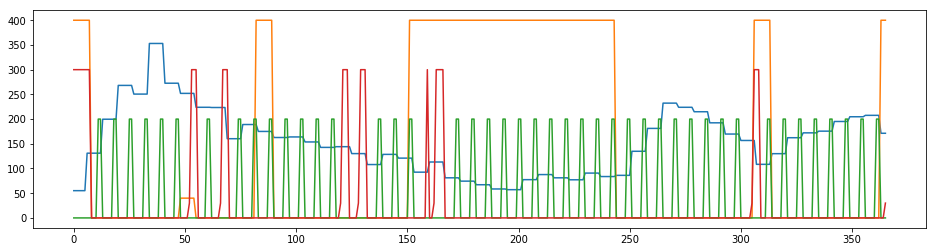

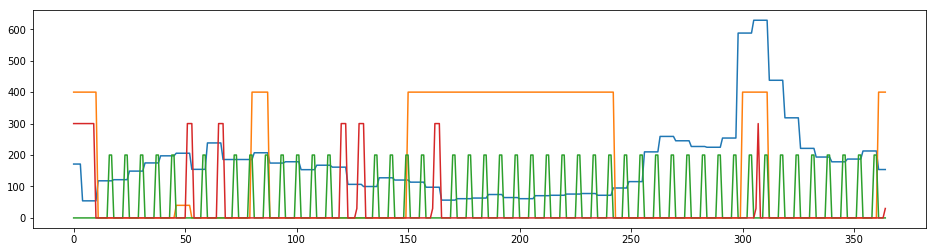

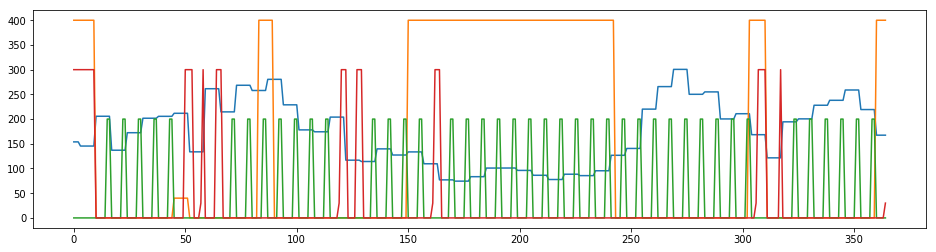

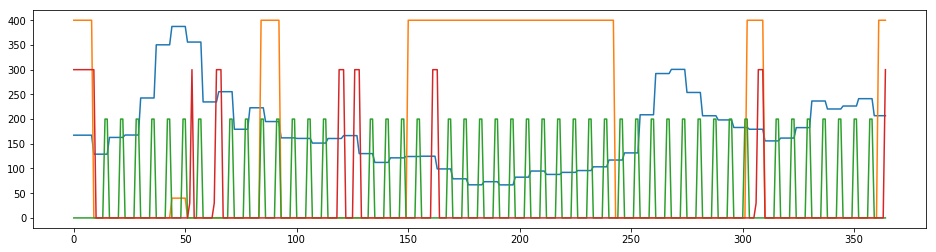

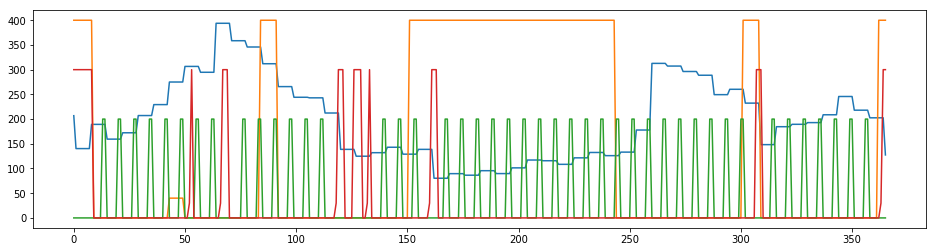

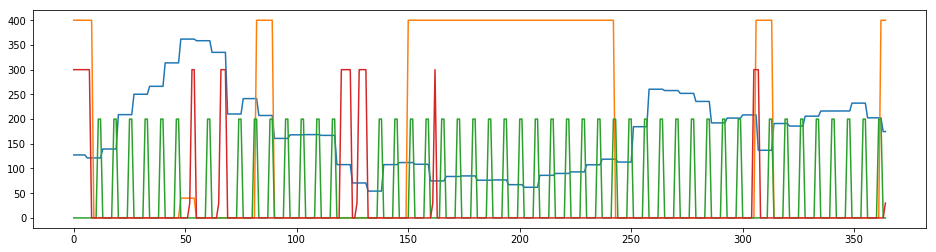

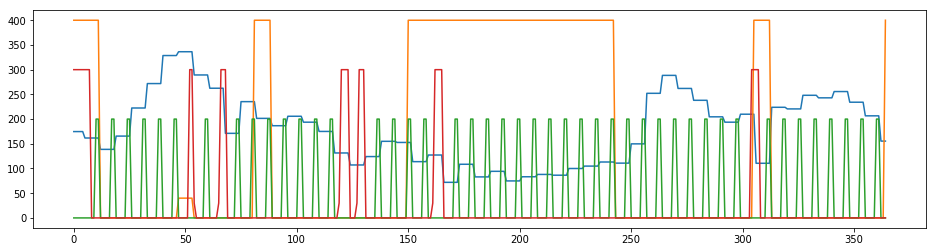

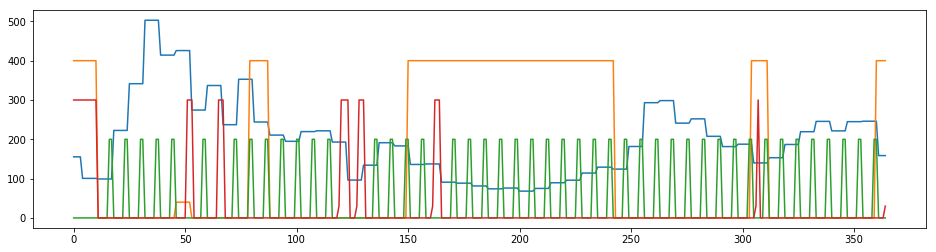

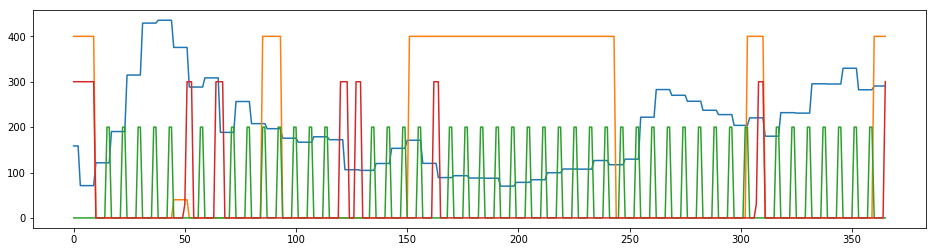

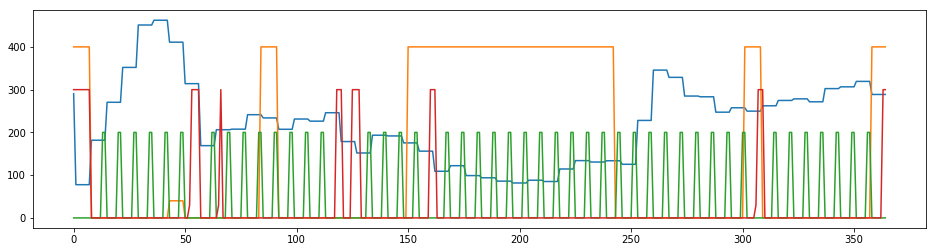

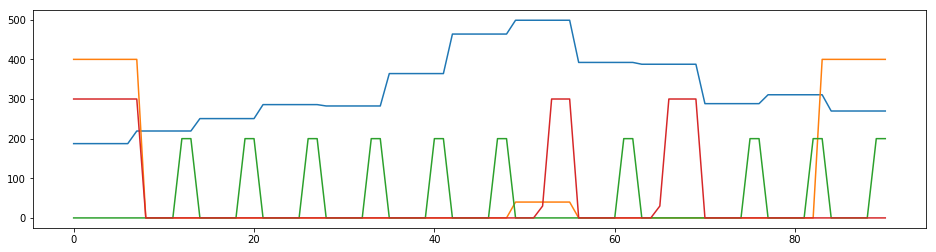

In [103]:
if experiment_shell_driven == False:

    years_count = int(len(merged)/365) + 1
    merged['date'] = pd.to_datetime(merged['date'],format='%d.%m.%y')

    epi_year_values = numpy.empty((years_count+2,366,))
    epi_year_values[:,:] = numpy.nan
    epi_year_breaks_values = numpy.empty((years_count+2,366,))
    epi_year_breaks_values[:,:] = numpy.nan
    epi_year_dayoff_values = numpy.empty((years_count+2,366,))
    epi_year_dayoff_values[:,:] = numpy.nan
    epi_year_holiday_values = numpy.empty((years_count+2,366,))
    epi_year_holiday_values[:,:] = numpy.nan

    epi_years = merged['date'].dt.year.drop_duplicates()
    i = 0
    for epi_year in epi_years :
        print(epi_year)
        merged_year = merged[merged['date'].dt.year == epi_year]

        epi_year_values[i,0:len(merged_year['Case No_count'].values[:])] = merged_year['Case No_count'].values[:]
        epi_year_breaks_values[i,0:len(merged_year['break_day'].values[:])] = merged_year['break_day'].values[:]
        epi_year_dayoff_values[i,0:len(merged_year['day_off'].values[:])] = merged_year['day_off'].values[:]
        epi_year_holiday_values[i,0:len(merged_year['holiday'].values[:])] = merged_year['holiday'].values[:]

        i+= 1
    i = 0
    # plot each column
    pyplot.figure(figsize=(16, 8))
    for epi_year in epi_years[:-1]:
    #    pyplot.subplot(len(epi_years), 1, i)
        pyplot.plot(epi_year_values[i, :])
    #    pyplot.title(agg_dataset.columns[group], y=0.5, loc='right')
        i += 1
    #pyplot.plot(epi_year_values[len(epi_years), :],linewidth=7)
    pyplot.show()

    i = 0
    for epi_year in epi_years[:-1]:
        print(epi_year)
        pyplot.figure(figsize=(16, 4))
    #    pyplot.subplot(len(epi_years), 1, i)
        pyplot.plot(epi_year_values[i, :])
        pyplot.plot(epi_year_breaks_values[i, :] * 400)
        pyplot.plot(epi_year_dayoff_values[i, :] * 200)
        pyplot.plot(epi_year_holiday_values[i, :] * 300)

    #    pyplot.title(agg_dataset.columns[group], y=0.5, loc='right')
        i += 1
    #pyplot.plot(epi_year_values[len(epi_years), :],linewidth=7)
    pyplot.show()

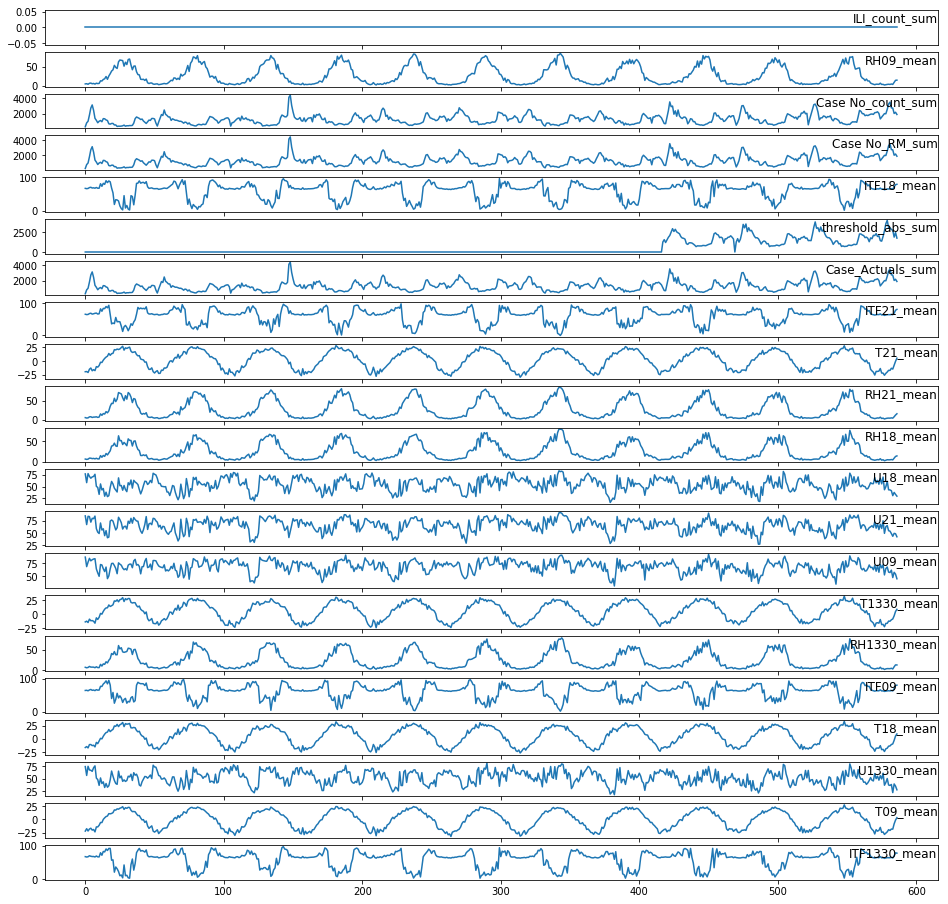

In [104]:
#merged['ILI_count'] = 0

#####dataset = merged[['Case No_count','Po_mean','RRRN_sum','U_mean','T_mean','Case Count Year Before', 'ILI_count','RH_mean','ITF_mean','Case No_RM']]

merged_grp = merged.groupby('epi_year_week').agg({
                                                  'T09': ["mean"], 
                                                  'U09': ["mean"],
                                                  'T1330': ["mean"], 
                                                  'U1330': ["mean"],
                                                  'T18': ["mean"], 
                                                  'U18': ["mean"],
                                                  'T21': ["mean"], 
                                                  'U21': ["mean"],
                                                  'Case No_count' : [sum], 
                                                  'ILI_count':[sum],
                                                  'RH09':["mean"],
                                                  'RH1330':["mean"],
                                                  'RH18':["mean"],
                                                  'RH21':["mean"],
                                                  'ITF09':["mean"],
                                                  'ITF1330':["mean"],
                                                  'ITF18':["mean"],
                                                  'ITF21':["mean"],
                                                  'Case No_RM' : [sum],
                                                  'Case_Actuals' : [sum],
                                                  'threshold_abs' : [sum]}) 
merged_grp.columns = ["_".join(x) for x in merged_grp.columns.ravel()]

values = merged_grp.values

i = 1
# plot each column
pyplot.figure(figsize=(16, 16))
for group in range(0,len(merged_grp.columns)):
    pyplot.subplot(len(merged_grp.columns), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(merged_grp.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()


In [105]:
merged.head(10)

,Case No_count,Case No_RM,Case_Actuals,ITF09,ITF1330,ITF18,ITF21,RH09,RH1330,RH18,...,iso_week,epi_week,epi_year,day_off,break_day,holiday,day_off_sat,day_off_sun,epi_year_week,threshold_abs
2007-01-01,42.142857,42.142857,42.142857,63.743566,66.755194,65.682371,64.552475,3.743566,6.755194,5.682371,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-02,42.142857,42.142857,42.142857,64.007817,67.319614,66.451333,65.072999,4.007817,7.319614,6.451333,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-03,42.142857,42.142857,42.142857,63.901543,67.426635,65.827562,65.228237,3.901543,7.426635,5.827562,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-04,42.142857,42.142857,42.142857,65.578179,67.993283,67.434418,66.587478,5.578179,7.993283,7.434418,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-05,42.142857,42.142857,42.142857,64.529731,67.458437,67.825828,67.699854,4.529731,7.458437,7.825828,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-06,42.142857,42.142857,42.142857,65.943873,66.649538,65.126256,64.385285,5.943873,6.649538,5.126256,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-07,42.142857,42.142857,42.142857,63.955950,66.787715,64.938871,64.879905,3.955950,6.787715,4.938871,...,1.0,1.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-01,NaN
2007-01-08,114.428571,114.428571,114.428571,66.794052,66.411380,64.975851,63.922127,6.794052,6.411380,4.975851,...,2.0,2.0,2007.0,0.0,1.0,1.0,0.0,0.0,2007-02,NaN
2007-01-09,114.428571,114.428571,114.428571,63.139613,64.910732,64.261778,63.951973,3.139613,4.910732,4.261778,...,2.0,2.0,2007.0,0.0,0.0,0.0,0.0,0.0,2007-02,NaN
2007-01-10,114.428571,114.428571,114.428571,65.209378,65.363858,65.572459,64.651748,5.209378,5.363858,5.572459,...,2.0,2.0,2007.0,0.0,0.0,0.0,0.0,0.0,2007-02,NaN


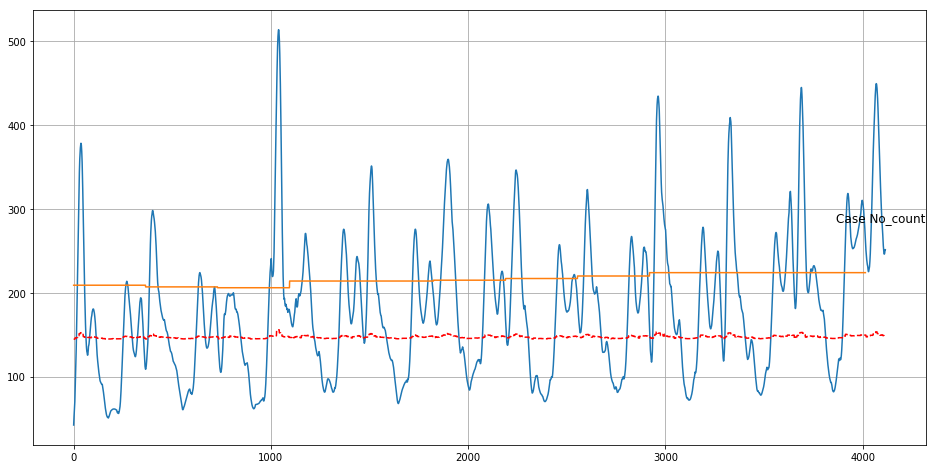

In [106]:
values = merged.values

#i = 1
# plot each column
pyplot.figure(figsize=(16, 8))
#for group in range(0,len(merged_grp.columns)):

pyplot.plot(savitzky_golay(values[:, 0],53,3))
pyplot.grid(b=True, which='both', color='0.65', linestyle='-')
pyplot.title(merged.columns[0], y=0.5, loc='right')

population = [209000, 207300, 206653, 214390, 214400, 215736, 217644, 220077, 224192, 224335, 224419]
#population = [21227, 21442, 21702, 22052, 22274, 22178, 21952, 21585, 21501, 21283, 20769]
population_curve = numpy.empty(11*365)

for i in range(0,11):
    for j in range(0,365):
        population_curve[i*365+j] = population[i] / 1000

pyplot.plot(population_curve)


x = numpy.asarray(list(range(len(values[:, 0]))), dtype=numpy.int)

# calc the trendline
z = numpy.polyfit(x,values[x, 0], 1)
p = numpy.poly1d(z)
pyplot.plot(x,p(values[x, 0]),"r--")

pyplot.show()





In [107]:
# Year-back feature for weekly dataset ...

merged_grp['Case Count Year Before'] = merged_grp['Case No_RM_sum']
values = merged_grp['Case Count Year Before'].values

back_delta = 52
for i in range(back_delta,len(values)):
    values[i] -= values[i-back_delta]
values[0:back_delta] =0

merged_grp['Case Count Year Before'] = values

# Year-back feature for daily dataset ...

merged['Case Count Year Before'] = merged['Case No_RM']
values = merged['Case Count Year Before'].values

back_delta = 365
for i in range(back_delta,len(values)):
    values[i] -= values[i-back_delta]
values[0:back_delta] = 0

merged['Case Count Year Before'] = values

# Case count difference ...

merged['case_count_diff'] = 0.0
if include_case_count_diff > 0:
    merged['case_count_diff'] = merged['Case No_RM'] - merged['Case No_RM'].shift(include_case_count_diff)
    merged.fillna(0, inplace=True)  # fill leading N/A 

# Rename grouped columns ...

merged_grp.rename(columns={
                          'T09_mean': 'T09', 
                          'U09_mean': 'U09',
                          'T1330_mean': 'T1330', 
                          'U1330_mean': 'U1330',
                          'T18_mean': 'T18', 
                          'U18_mean': 'U18',
                          'T21_mean': 'T21', 
                          'U21_mean': 'U21',
                          'Case No_count_sum':'Case No_count',
                          'ILI_count_sum' : 'ILI_count',
                          'RH09_mean':'RH09',
                          'RH1330_mean': 'RH1330',
                          'RH18_mean':'RH18',
                          'RH21_mean':'RH21',
                          'ITF09_mean':'ITF09',
                          'ITF1330_mean':'ITF1330',
                          'ITF18_mean':'ITF18',
                          'ITF21_mean':'ITF21',
                          'Case No_RM_sum':'Case No_RM',
                          'Case_Actuals_sum' : 'Case_Actuals',
                          'threshold_abs_sum' : 'threshold_abs'}, inplace=True)



In [108]:
# Prepare a dataset dataframe for further processing ...

if Aggregate_Cases == True:
    dataset = merged_grp
else:
    dataset = merged

datasetA = dataset [['Case_Actuals','threshold_abs']]
datasetDates = dataset.index

dataset = dataset[[
      'Case No_count',
      'T09', 
      'U09',
      'T1330', 
      'U1330',
      'T18', 
      'U18', 
      'T21', 
      'U21', 
      'ILI_count',
      'RH09',
      'RH1330',
      'RH18',
      'RH21',
      'ITF09',
      'ITF1330',
      'ITF18',
      'ITF21',
      'day_off',
      'break_day',
      'holiday',
      'day_off_sat',
      'day_off_sun',
      'case_count_diff',
      'Case Count Year Before',
      'Case No_RM'
]]


    
# delete the first and the last rows
dataset = dataset[1:-1]
datasetA = datasetA[1:-1]
datasetDates = datasetDates[1:-1]

In [109]:
# Substract seasonal from the dataset
import statsmodels.api as sm

my_pandas_series = dataset['Case No_count']
decomposed = sm.tsa.seasonal_decompose(my_pandas_series.values, freq=52)

residual = decomposed.resid
seasonal = decomposed.seasonal
trend = decomposed.trend

if substract_seasonal == True or split_seasonal_residuals == True:
    
    dataset['Case No_count'] -= seasonal # only residual left
    
if substract_seasonal == True:

    dataset['Case No_RM'] -= seasonal
    
if split_seasonal_residuals == True:
    
    dataset['Seasonal_count'] = seasonal # seasonal counts

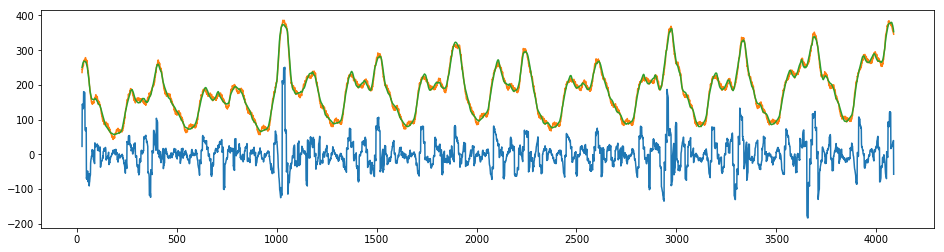

In [110]:
pyplot.figure(figsize=(16, 4))
pyplot.plot(residual)
pyplot.plot(seasonal+trend)
pyplot.plot(trend)
#pyplot.plot(seasonal+trend+residual)

In [111]:
# MAKE 'Case No_RM' the last column

columns = [column for column in dataset if column != 'Case No_RM'] + ['Case No_RM']
dataset = dataset[columns]

In [112]:
# PREPARE AND CONVERT FOR SUPERVISED LEARNING

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

dataset.fillna(0,inplace=True)

#dataset.drop(['T_mean'], axis=1, inplace=True)

if include_weather == False :
    dataset.drop(['T09', 'U09', 'T1330', 'U1330', 'T18', 'U18', 'T21', 'U21'], axis=1, inplace=True)
if include_weather_inside_relative_humidity == False:
    dataset.drop(['RH09', 'RH1330', 'RH18', 'RH21'], axis=1, inplace=True)
if include_weather_ITF == False:
    dataset.drop(['ITF09', 'ITF1330', 'ITF18', 'ITF21'], axis=1, inplace=True)
    
if include_case_count_year_before == False:
    dataset.drop(['Case Count Year Before'], axis=1, inplace=True)

if include_case_counts == False:
    dataset.drop(['Case No_count'], axis=1, inplace=True)
    
if add_ili_counts == False:
    dataset.drop(['ILI_count'], axis=1, inplace=True)    

if include_day_off == False:
    dataset.drop(['day_off'], axis=1, inplace=True)    

if include_school_breaks == False:
    dataset.drop(['break_day'], axis=1, inplace=True) 
    
if include_holiday == False:
    dataset.drop(['holiday'], axis=1, inplace=True) 

if include_day_off_sat == False:
    dataset.drop(['day_off_sat'], axis=1, inplace=True) 

if include_day_off_sun == False:
    dataset.drop(['day_off_sun'], axis=1, inplace=True) 

if include_case_count_diff > 0:
    dataset.drop(['case_count_diff'], axis=1, inplace=True)
    
values = dataset.values

# ensure all data is float
values = values.astype('float64')
# normalize features
if normalize_features == True:
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
else:
    scaled=values

# frame as supervised learning
# INPUT: n_days = 7 ### 7 days = week, 14 days = 2 weeks

n_features = len(dataset.columns) - 1

reframed = series_to_supervised(scaled, n_days, 1)

# drop (t-7), (t-6), ...(t-1) targets leaving only the (t) target as the last column

print("dropped colums: ")
for i in range(n_days,0,-1):
   reframed.drop(reframed.columns[i*(n_features+1)-1], axis=1, inplace=True)
#   print(str(i*n_features),':', str(i), " | ")

# drop (t) vector except the target
    
reframed.drop(reframed.columns[numpy.arange(len(reframed.columns)-n_features-1,len(reframed.columns)-1)], axis=1, inplace=True)
print("dropped column: " + str(numpy.arange(len(reframed.columns)-n_features-1,len(reframed.columns)-1)) )

####print(reframed.head())

#shift the targets by predict days...

#reframed.iloc[ :, -1:] = reframed.iloc[ :, -1:].shift(periods=-predict_days+1)
values = reframed.values
if predict_days-1 > 0 :
    values[:-predict_days+1,-1] = values[predict_days-1:,-1]

print("shifted for prediction by (days):" + str(predict_days))

# Actuals ...
valuesA = datasetA[n_days:].values  # shift to the left replacing first n_days
valuesA = valuesA.astype('float64')

# Dates of the set
valuesDates = datasetDates[n_days:].values

valuesF = dataset[n_days:].values  # shift to the left replacing first n_days
valuesF = valuesF.astype('float64')


dropped colums: 
dropped column: [143 144 145 146 147 148 149 150 151 152 153]
shifted for prediction by (days):7


In [113]:
reframed.head(10)

,var1(t-14),var2(t-14),var3(t-14),var4(t-14),var5(t-14),var6(t-14),var7(t-14),var8(t-14),var9(t-14),var10(t-14),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t)
14,0.184325,0.900000,0.237053,0.725275,0.236390,0.784946,0.223903,0.775281,0.0,1.0,...,0.260394,0.560440,0.230659,0.677419,0.195159,0.775281,0.0,0.0,0.0,0.368331
15,0.181422,0.888889,0.239971,0.725275,0.229226,0.731183,0.217852,0.831461,0.0,1.0,...,0.182349,0.725275,0.177650,0.784946,0.161876,0.820225,0.0,0.0,0.0,0.368331
16,0.248186,0.888889,0.235594,0.807692,0.252149,0.838710,0.252648,0.887640,0.0,1.0,...,0.150985,0.780220,0.183381,0.784946,0.166415,0.831461,0.0,0.0,0.0,0.368331
17,0.208999,0.888889,0.210066,0.862637,0.262178,0.838710,0.284418,0.887640,0.0,1.0,...,0.180890,0.807692,0.247851,0.784946,0.231467,0.831461,0.0,0.0,0.0,0.368331
18,0.283019,0.777778,0.246535,0.615385,0.232092,0.623656,0.195159,0.775281,0.0,1.0,...,0.298322,0.714286,0.266476,0.731183,0.225416,0.831461,0.0,0.0,0.0,0.368331
19,0.194485,0.833333,0.266958,0.560440,0.224928,0.623656,0.204236,0.831461,0.0,1.0,...,0.237053,0.697802,0.222063,0.731183,0.211800,0.831461,1.0,0.0,0.0,0.368331
20,0.309144,0.777778,0.217360,0.697802,0.226361,0.623656,0.229955,0.550562,0.0,1.0,...,0.233406,0.780220,0.247851,0.784946,0.226929,0.831461,1.0,0.0,0.0,0.368331
21,0.216255,0.555556,0.202042,0.560440,0.212034,0.569892,0.231467,0.550562,0.0,0.0,...,0.254559,0.725275,0.275072,0.731183,0.246596,0.775281,0.0,0.0,0.0,0.591717
22,0.313498,0.555556,0.296864,0.351648,0.335244,0.376344,0.248109,0.606742,0.0,0.0,...,0.344274,0.587912,0.333811,0.602151,0.299546,0.775281,0.0,0.0,0.0,0.591717
23,0.283019,0.555556,0.234136,0.478022,0.242120,0.516129,0.189107,0.606742,0.0,0.0,...,0.410649,0.417582,0.405444,0.516129,0.349470,0.775281,0.0,0.0,0.0,0.591717


In [114]:
# SPLIT INTO TRAINING-VALIDATION-TEST DATASETS

# split into train and test sets

# CUT THE CASE-BASED PART

if Daily_Part == False  :
    values = values[: -len(cases_dataset)] # !!!! CUT OUT THE DAILY DATASET !!!!
    valuesA = valuesA[: -len(cases_dataset)]
    valuesF = valuesF[: -len(cases_dataset)]
    valuesDates = valuesDates[: -len(cases_dataset)]
if Aggregate_Part == False :
    values = values[-len(cases_dataset): ] # !!!! CUT OUT AGGREGATE DATASET !!!!
    valuesA = valuesA[-len(cases_dataset): ]
    valuesF = valuesF[-len(cases_dataset): ]
    valuesDates = valuesDates[-len(cases_dataset): ]
    
#n_train_days = int((len(values) )* 0.6)
#n_test_days = int((len(values)) * 0.08) # 5% -> 8%
n_train_days = int((len(values) )* 0.67)
n_test_days = int((len(values)) * 0.08)


train = values[:n_train_days, :]
trainA = valuesA[:n_train_days, :]
trainF = valuesF[:n_train_days, :]
trainDates = valuesDates[:n_train_days]

test = values[n_train_days:n_test_days+n_train_days, :]
testA = valuesA[n_train_days:n_test_days+n_train_days, :]
testF = valuesF[n_train_days:n_test_days+n_train_days, :]
testDates = valuesDates[n_train_days:n_test_days+n_train_days]

#test2 = values[n_test_days+n_train_days:, :]
#test2A = valuesA[n_test_days+n_train_days:, :]
#test2F = valuesF[n_test_days+n_train_days:, :]
#test2Dates = valuesDates[n_test_days+n_train_days:]

test2 = values[n_train_days:, :]
test2A = valuesA[n_train_days:, :]
test2F = valuesF[n_train_days:, :]
test2Dates = valuesDates[n_train_days:]

n_test2_days = len(test2)

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
test2_X, test2_y = test2[:, :n_obs], test2[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
test2_X = test2_X.reshape((test2_X.shape[0], n_days, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, test2_X.shape, test2_y.shape)

((2747, 154), 2747, (2747,))
((2747, 14, 11), (2747,), (328, 14, 11), (328,), (1353, 14, 11), (1353,))


In [115]:
reframed.head(5).round(2)

,var1(t-14),var2(t-14),var3(t-14),var4(t-14),var5(t-14),var6(t-14),var7(t-14),var8(t-14),var9(t-14),var10(t-14),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t)
14,0.18,0.90,0.24,0.73,0.24,0.78,0.22,0.78,0.0,1.0,...,0.26,0.56,0.23,0.68,0.20,0.78,0.0,0.0,0.0,0.37
15,0.18,0.89,0.24,0.73,0.23,0.73,0.22,0.83,0.0,1.0,...,0.18,0.73,0.18,0.78,0.16,0.82,0.0,0.0,0.0,0.37
16,0.25,0.89,0.24,0.81,0.25,0.84,0.25,0.89,0.0,1.0,...,0.15,0.78,0.18,0.78,0.17,0.83,0.0,0.0,0.0,0.37
17,0.21,0.89,0.21,0.86,0.26,0.84,0.28,0.89,0.0,1.0,...,0.18,0.81,0.25,0.78,0.23,0.83,0.0,0.0,0.0,0.37
18,0.28,0.78,0.25,0.62,0.23,0.62,0.20,0.78,0.0,1.0,...,0.30,0.71,0.27,0.73,0.23,0.83,0.0,0.0,0.0,0.37


In [116]:
dataset.head(5)

,T09,U09,T1330,U1330,T18,U18,T21,U21,day_off,break_day,holiday,Case No_RM
2007-01-02,-24.2,91.0,-13.70,75.0,-16.3,80.0,-19.5,80.0,0.0,1.0,1.0,42.142857
2007-01-03,-24.4,90.0,-13.50,75.0,-16.8,75.0,-19.9,85.0,0.0,1.0,1.0,42.142857
2007-01-04,-19.8,90.0,-13.80,82.5,-15.2,85.0,-17.6,90.0,0.0,1.0,1.0,42.142857
2007-01-05,-22.5,90.0,-15.55,87.5,-14.5,85.0,-15.5,90.0,0.0,1.0,1.0,42.142857
2007-01-06,-17.4,80.0,-13.05,65.0,-16.6,65.0,-21.4,80.0,0.0,1.0,1.0,42.142857


2747
Train on 2747 samples, validate on 328 samples
Epoch 1/500
 - 3s - loss: 0.0235 - val_loss: 0.0206
Epoch 2/500
 - 1s - loss: 0.0125 - val_loss: 0.0196
Epoch 3/500
 - 1s - loss: 0.0122 - val_loss: 0.0196
Epoch 4/500
 - 1s - loss: 0.0119 - val_loss: 0.0194
Epoch 5/500
 - 1s - loss: 0.0117 - val_loss: 0.0192
Epoch 6/500
 - 1s - loss: 0.0116 - val_loss: 0.0191
Epoch 7/500
 - 1s - loss: 0.0114 - val_loss: 0.0190
Epoch 8/500
 - 1s - loss: 0.0113 - val_loss: 0.0189
Epoch 9/500
 - 1s - loss: 0.0112 - val_loss: 0.0188
Epoch 10/500
 - 1s - loss: 0.0111 - val_loss: 0.0188
Epoch 11/500
 - 1s - loss: 0.0110 - val_loss: 0.0187
Epoch 12/500
 - 1s - loss: 0.0109 - val_loss: 0.0187
Epoch 13/500
 - 1s - loss: 0.0108 - val_loss: 0.0187
Epoch 14/500
 - 1s - loss: 0.0108 - val_loss: 0.0187
Epoch 15/500
 - 1s - loss: 0.0107 - val_loss: 0.0186
Epoch 16/500
 - 1s - loss: 0.0107 - val_loss: 0.0186
Epoch 17/500
 - 1s - loss: 0.0106 - val_loss: 0.0186
Epoch 18/500
 - 1s - loss: 0.0106 - val_loss: 0.0186
Epo

Epoch 154/500
 - 1s - loss: 0.0080 - val_loss: 0.0135
Epoch 155/500
 - 1s - loss: 0.0079 - val_loss: 0.0136
Epoch 156/500
 - 1s - loss: 0.0079 - val_loss: 0.0136
Epoch 157/500
 - 1s - loss: 0.0079 - val_loss: 0.0136
Epoch 158/500
 - 1s - loss: 0.0078 - val_loss: 0.0136
Epoch 159/500
 - 1s - loss: 0.0077 - val_loss: 0.0136
Epoch 160/500
 - 1s - loss: 0.0076 - val_loss: 0.0136
Epoch 161/500
 - 1s - loss: 0.0076 - val_loss: 0.0136
Epoch 162/500
 - 1s - loss: 0.0076 - val_loss: 0.0136
Epoch 163/500
 - 1s - loss: 0.0076 - val_loss: 0.0136
Epoch 164/500
 - 1s - loss: 0.0076 - val_loss: 0.0136
Epoch 165/500
 - 1s - loss: 0.0076 - val_loss: 0.0136
Epoch 166/500
 - 1s - loss: 0.0076 - val_loss: 0.0134
Epoch 167/500
 - 1s - loss: 0.0075 - val_loss: 0.0136
Epoch 168/500
 - 1s - loss: 0.0075 - val_loss: 0.0134
Epoch 169/500
 - 1s - loss: 0.0074 - val_loss: 0.0136


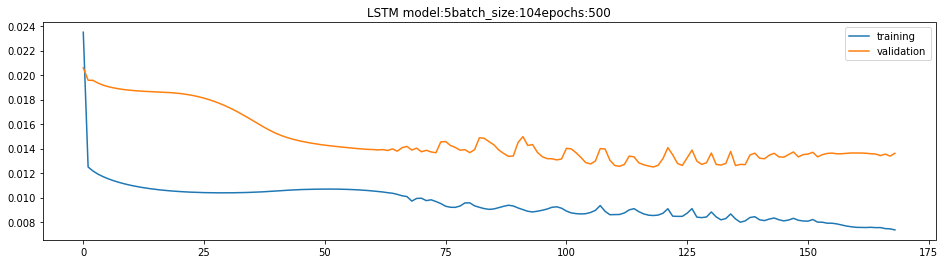

In [117]:
# TRAIN AND VALIDATE THE NETWORK


from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Dense, Activation, Dropout
import keras.backend as K
import keras

import datetime as dt


print(train_y.shape[0])

# define custom loss function
def amae(a, p):
    xproduct = K.concatenate([a[:,:1],a[:,1:] - a[:,:-1]])#
#    xproduct = -xproduct
    xproduct *= -0.
    xdelta = p - a
    xdelta = K.abs(xdelta) + xdelta * xproduct
#    product = K.concatenate(a[:,0], a[:,1:] - a[:,:-1])
#    product[0] = 0
#    product = - product * 10
#    delta = p - a
#    delta = abs(delta) + (delta * product)
#    return sum(delta)/len(delta)

    return K.mean(xdelta)
   
 
# design network
model = Sequential()


if model_type == 1:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
#####model.compile(loss=amae, optimizer='adam')

if model_type == 0:
    model.add(LSTM(ModelNeuronsQty, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')


if model_type == 3:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

if model_type == 2:
    model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(15))
    model.add(Dropout(n_dropout))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(loss='mae', optimizer='RMSprop')

if model_type == 4:
    model.add(LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(1))
 #   model.add(Activation('relu'))
    model.compile(loss='mae', optimizer='adam')

if model_type == 5:
    model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(15))
    model.add(Dropout(n_dropout))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

if model_type == 6:
    model.add(LSTM(25, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(25))
    model.add(Dropout(0.15))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

if model_type == 7:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dropout(n_dropout))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')

if model_type == 8:
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(ModelNeuronsQty))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')

if model_type == 9:
#    model.add(layers.Embedding(1000, 128,input_length=500,name='embed'))
    model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(n_dropout))
    model.add(LSTM(15))
    model.add(Dropout(n_dropout))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')



#model.add(layers.GRU(32, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')

#model = Sequential()
#model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')

#model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.GRU(64, activation='relu',dropout=0.1,recurrent_dropout=0.5))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')

#model.add(layers.Bidirectional(layers.GRU(32), input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(layers.Dense(1))
#model.compile(optimizer=RMSprop(), loss='mae')



#callbacks_list = [
#        keras.callbacks.EarlyStopping(
#            monitor='acc',
#            patience=1,
#        ),
#        keras.callbacks.ModelCheckpoint(
#            filepath='my_model.h5',
#            monitor='val_loss',
#            save_best_only=True,
#        )
#]





# fit network
#history = model.fit(train_X, train_y, epochs=epochs_number, batch_size=52, validation_data=(test_X, test_y), verbose=2, shuffle=False)


#callback_list = [
#        keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,),
#        keras.callbacks.TensorBoard(log_dir='./log_dir',histogram_freq=1,embeddings_freq=1,) ]
#        keras.callbacks.TensorBoard(log_dir='./log_dir',histogram_freq=0, write_graph=True, write_images=True,) ]


#callbacks_list = [
#        keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,),  # loss
#        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,)
#]

###callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,)]  # loss
callback_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,),
                 keras.callbacks.TensorBoard(log_dir='./log_dir',histogram_freq=0,embeddings_freq=0,) ]
history = model.fit(train_X, train_y, epochs=epochs_number, batch_size=52, callbacks=callback_list, validation_data=(test_X, test_y), verbose=2, shuffle=False)



file_name = dt.datetime.today().strftime('%Y-%m-%d %H:%M')
Comment += "LSTM model:" + str(model_type) + "batch_size:" + "104" + "epochs:" + str(epochs_number)

# plot history
pyplot.figure(figsize=(16, 4))

pyplot.plot(history.history['loss'], label='training')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.title( Comment )
pyplot.savefig('Model Runs History/' + 'training-validation-' +  file_name  + '.pdf')
pyplot.show()



In [118]:
i=0
#for layer in model.layers:
#    weights[i] = layer.get_weights()
#    print("layer", layer.get_config())
##    print(weights.shape)
#    print(weights)
#    i+=1

#w1 = model.layers[4].get_weights()[0]
#w2 = model.layers[2].get_weights()[1]
#w3 = model.layers[2].get_weights()[2]

#print(w1.shape)
#print(w2.shape)
#print(w3.shape)

In [119]:
###weights[0][0].round(2)

In [120]:
model_type = 9 

In [121]:
from keras.utils import plot_model
plot_model(model, show_shapes = True, to_file='Model Runs History/model-' + file_name + '.png')
#plot_model(model)

In [122]:
# MAKE A PREDICTION WITH TEST DATA

X = test2_X.copy() # inputs (features)
y = test2_y.copy() # targets
A = test2A.copy()
F = test2F.copy()
D = test2Dates.copy()

# make a prediction
yhat = model.predict(X)
# invert scaling for forecast
X = X.reshape((X.shape[0], n_days*n_features))
inv_yhat = concatenate((X[:,:n_features],yhat), axis=1)
if normalize_features == True:
    inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_f00 = inv_yhat[:,-n_days*n_features]
#inv_f01 = inv_yhat[:,-n_days*n_features+1]
inv_yhat = inv_yhat[:,-1] # the last column presents the prediction (t),(t+1),(t+2) [+predict_days-1]

if predict_days-1 > 0 :
    inv_yhat[predict_days-1:] = inv_yhat[:-predict_days+1] # since the prediction is for the future than shift to the future correleate w/ actual

# invert scaling for actual
y = y.reshape((len(y), 1)) # targets
inv_y = concatenate((X[:,-n_features:],y), axis=1)
if normalize_features == True:
    inv_y = scaler.inverse_transform(inv_y)



inv_yd = inv_y[:,-1-n_features] # actual daily counts (t-1),(t),(t+1),...
# shift daily actual counts 
inv_yd[:-1] = inv_yd[1:] #shift daily counts to get values for (t) from (t-1), the [0] gets lost, [-1] is empitied
inv_yd[-1] = numpy.nan




inv_y = inv_y[:,-1] # targets (t),(t+1),(t+2) [+predict_days-1]
# shift daily targets back (they were shifted into the past by predict_days)
if predict_days-1 > 0 :
    inv_y[predict_days-1:] = inv_y[:-predict_days+1]


# cut the tail predict_days 
if predict_days-1 > 0 :
    inv_prediction = inv_yhat[predict_days-1:-predict_days+1]
    inv_actuals = inv_yd[predict_days-1:-predict_days+1]
    inv_targets = inv_y[predict_days-1:-predict_days+1]
    inv_actualsA = A[predict_days-1:-predict_days+1,0]
    inv_thresholds = A[predict_days-1:-predict_days+1,1]
    inv_featuresF = F[predict_days-1:-predict_days+1,:-1]
    inv_actualsDates = D[predict_days-1:-predict_days+1]

else:
    inv_prediction = inv_yhat[:-1]
    inv_actuals = inv_yd[:-1]
    inv_targets = inv_y[:-1]
    inv_actualsA = A[:-1,0]
    inv_thresholds = A[:-1,1]
    inv_featuresF = F[:-1,:-1]
    inv_actualsDates = D[:-1,:-1]

# seasonal adjuster
if substract_seasonal == True:
    seasonal_test = seasonal[-len(inv_prediction)-1:-1]
    inv_prediction += seasonal_test
    inv_actuals += seasonal_test
    inv_targets += seasonal_test
    dataset['Case No_RM'] += seasonal
    dataset['Case No_count'] += seasonal
if split_seasonal_residuals == True:
    seasonal_test = seasonal[-len(inv_prediction)-1:-1]
    inv_actuals += seasonal_test
    dataset['Case No_count'] += seasonal
    
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_actuals, inv_prediction))
print('Test RMSE: %.3f' % rmse)

from sklearn.metrics import mean_absolute_error

#calculate MAE
###mae = mean_absolute_error(inv_actuals, inv_prediction)
mae = mean_absolute_error(inv_actualsA[:], inv_prediction[:])
print('Test MAE: %.3f' % mae)

import numpy

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = numpy.array(y_true), numpy.array(y_pred)
    return numpy.mean(numpy.abs((y_true - y_pred) / y_true)) * 100

#calculate MAPE
#mape = mean_absolute_percentage_error(inv_actuals, inv_prediction)
mape = mean_absolute_percentage_error(inv_actualsA[:], inv_prediction)


print('Test MAPE: %.3f' % mape + '%')

# COMPARE ACTUALS WITH ROLLING AVERAGE
# calculate MAPE

def rolling_average(a, n=7) :
    ret = numpy.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


#inv_rolling_actuals = rolling_average(inv_actuals)
inv_rolling_actuals = savitzky_golay(inv_actualsA[:],5,2)

mape2 = mean_absolute_percentage_error(inv_actualsA[0:len(inv_rolling_actuals)],inv_rolling_actuals[:])
print('Actuals vs S-G MAPE: %.3f' % mape2 + '%')

# COMPARE ACTUALS WITH TARGETS
# calculate MAPE

def rolling_average(a, n=7) :
    ret = numpy.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

#inv_y_ra = rolling_average(inv_targets)
#inv_y_ra = savitzky_golay(inv_targets,5,2)

mape3 = mean_absolute_percentage_error(inv_targets[0:len(inv_rolling_actuals)],inv_rolling_actuals)
print('Targets vs S-G MAPE: %.3f' % mape3 + '%')

mape4 = mean_absolute_percentage_error(inv_rolling_actuals,inv_prediction[0:len(inv_rolling_actuals)])
print('S-G vs Forecast MAPE: %.3f' % mape4 + '%')

Test RMSE: 209.021
Test MAE: 44.390
Test MAPE: 20.827%
Actuals vs S-G MAPE: 1.872%
Targets vs S-G MAPE: 1.872%
S-G vs Forecast MAPE: 20.511%


In [123]:
inv_actualsA[:].shape

(1341,)

In [124]:

inv_rolling_actuals.shape


(1341,)

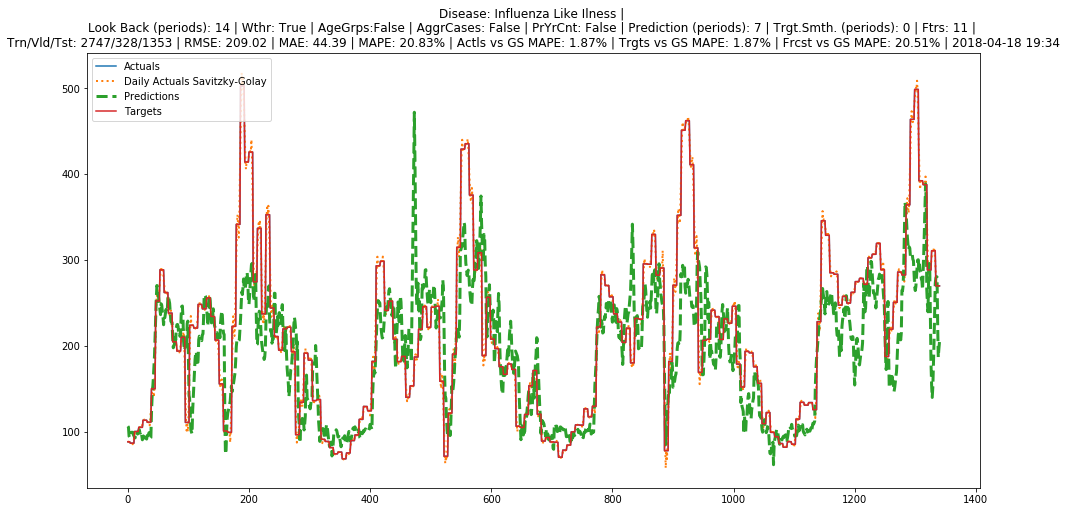

In [125]:
# plot baseline and predictions

def rolling_average(a, n=7) :
    ret = numpy.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

pyplot.figure(figsize=(16, 8))
#pyplot.plot(inv_targets, label="Targets")
pyplot.title("Disease: " + Disease + " | \n" +
             "Look Back (periods): " + str(n_days) + " | " +
             "Wthr: " + str(include_weather)  + " | " +
             "AgeGrps:" + str(include_age_groups) + " | " +
             "AggrCases: " + str(Aggregate_Cases) + " | " +
             "PrYrCnt: " + str(include_case_count_year_before) + " | " +

             "Prediction (periods): " + str(predict_days) + " | " + 
             "Trgt.Smth. (periods): " + str(smoothing) + " | " +
             "Ftrs: " + str(n_features)  + " | \n" +
             
             "Trn/Vld/Tst: " + str(n_train_days) + "/" + str(n_test_days) + "/" + str(n_test2_days) + " | " +
             "RMSE: " + str("%.2f" % rmse) + " | " +
             "MAE: " + str("%.2f" % mae) + " | " +
             "MAPE: " + str("%.2f" % mape) + "% | " +
             "Actls vs GS MAPE: "  + str("%.2f" % mape2) + "% | " +
             "Trgts vs GS MAPE: "  + str("%.2f" % mape3) + "% | " +
             "Frcst vs GS MAPE: "  + str("%.2f" % mape4) + "% | " +
             file_name
            )

#pyplot.plot(inv_actuals, label="Daily Actuals") # daily actuals

pyplot.plot(inv_actualsA, label="Actuals") # daily actuals


#pyplot.plot(rolling_average(inv_actuals), label="Daily Actuals Rolling Average") #rolling average of the daily actuals
ts = pd.Series(inv_actualsA[:])
#pyplot.plot(ts.rolling(window=5,min_periods=1).mean(), label = "Daily Actuals Rolling AverageDF")

pyplot.plot(savitzky_golay(inv_actualsA[:],7,2), ':', label = "Daily Actuals Savitzky-Golay", linewidth=2.0)

pyplot.plot(inv_prediction,'--', label="Predictions", linewidth=3.0)  # prediction

pyplot.plot(inv_targets, label="Targets")  # targets
##pyplot.plot(rolling_average(inv_prediction),'--', "Targets Rolling Average")

if substract_seasonal == True:
    pyplot.plot(seasonal_test, '--', label="Seasonal")  # seasonal_test

pyplot.legend(loc="upper left")

pyplot.savefig('Model Runs History/' + 'graph-' +  file_name  + '.pdf')
pyplot.show()


import csv

with open('Model Runs History/' + 'data-' + file_name + '.csv', 'w') as file:
    writer=csv.writer(file)
    writer.writerow(inv_actualsDates)
    writer.writerow(inv_actualsA[:])
    writer.writerow(inv_prediction)

#print('Model Runs History/' + 'graph-' +  file_name  + '.pdf', "\n", 'Model Runs History/' + 'data-' + file_name + '.csv')



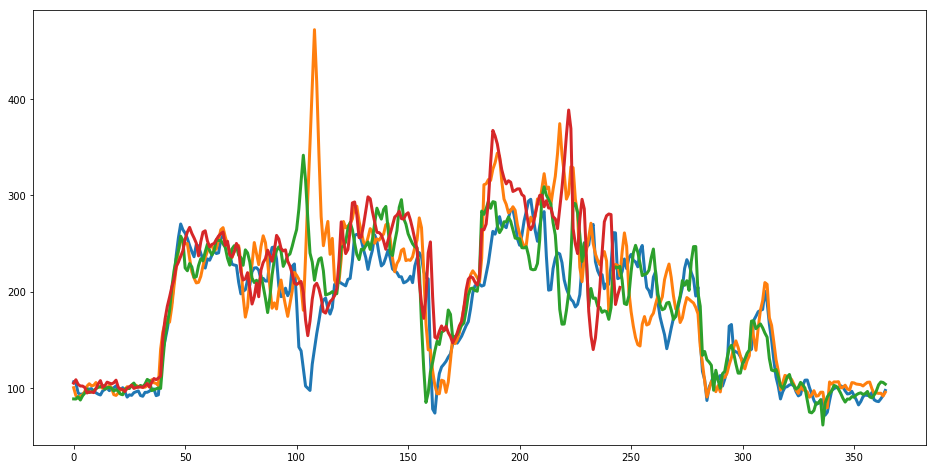

In [126]:
pyplot.figure(figsize=(16, 8))

for i in range(0,4):
    pyplot.plot(inv_prediction[i*365:min((i+1)*365,len(inv_prediction))], linewidth=3.0)  # prediction

pyplot.savefig('Model Runs History/' + 'stacked-predictions-' +  file_name  + '.pdf')
pyplot.show()

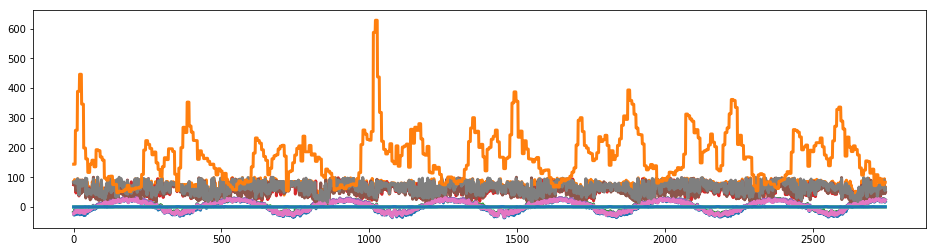

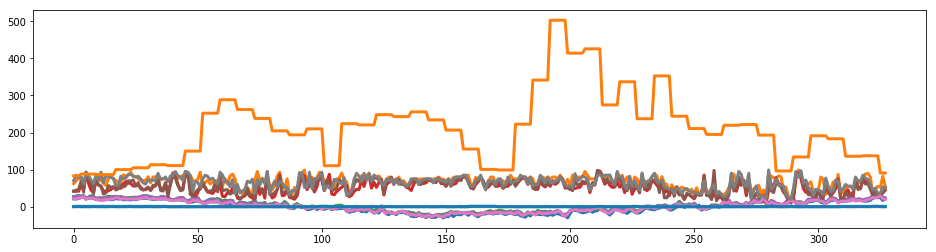

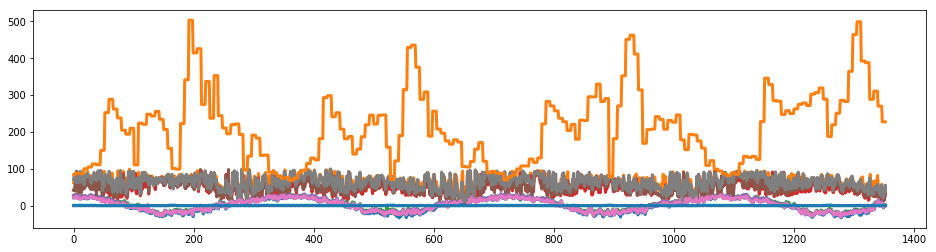

In [127]:
pyplot.figure(figsize=(16, 4))
pyplot.plot(trainF, linewidth=3.0)  # prediction
pyplot.show()

pyplot.figure(figsize=(16, 4))
pyplot.plot(testF, linewidth=3.0)  # prediction
pyplot.show()

pyplot.figure(figsize=(16, 4))
pyplot.plot(test2F, linewidth=3.0)  # prediction
pyplot.show()

2014-07-31


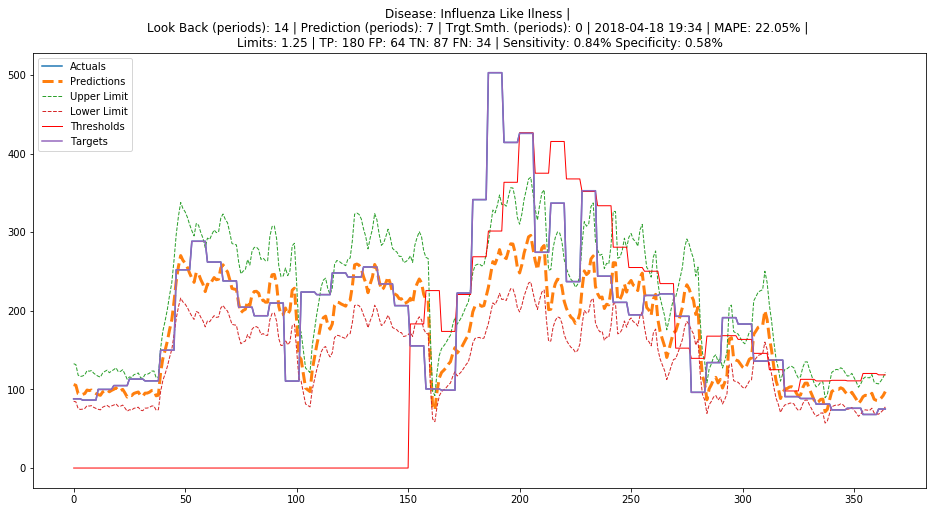

2015-07-31


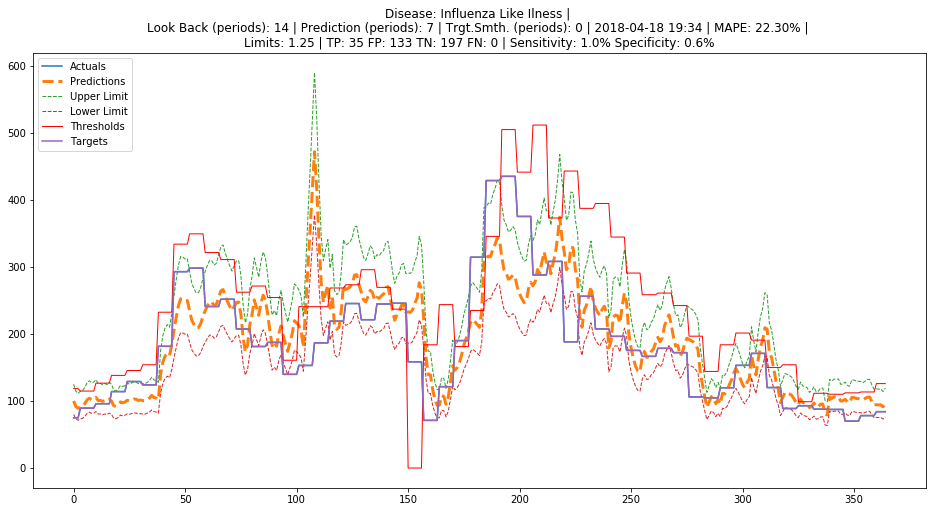

2016-07-30


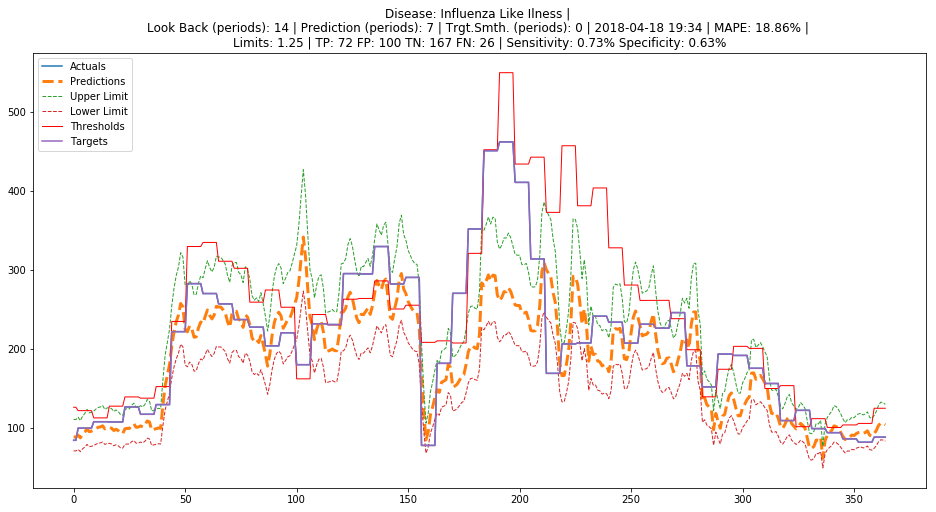

2017-07-30


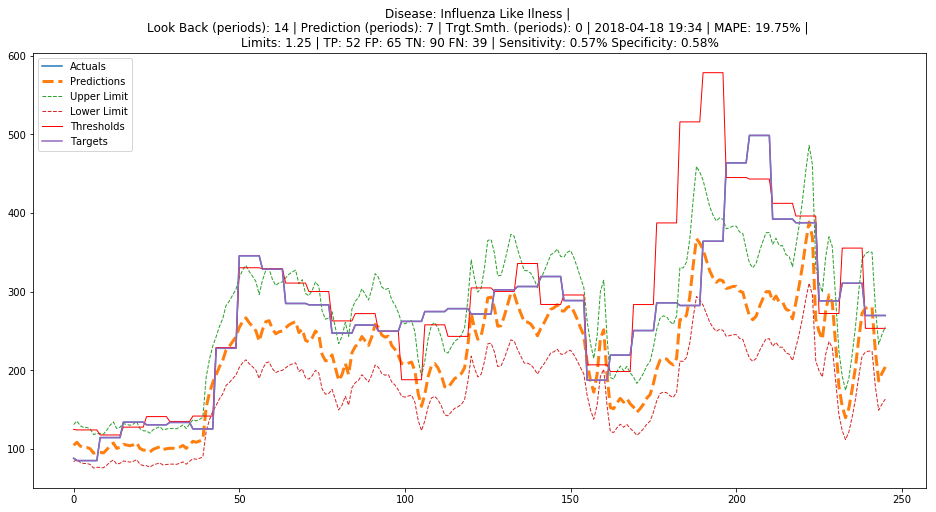

In [128]:
# 

inv_error = inv_prediction - inv_actualsA[:]
inv_error_percent = inv_error / inv_actualsA[:]

for i in range(1,40):
    test = (abs(inv_error_percent) < i/100.)
    if (test.sum() * 100.  / len(test)).round(2) >= 70:
        i -= 1
        break

limits_coeff = 1. + i/100.

for i in range(0,4):
    
    i1 = 365 * i
    i2 = 365 * i + 365

    
    
    # True Positives
    TP = sum((inv_prediction[i1:i2] * limits_coeff >= inv_thresholds[i1:i2]) & (inv_actualsA[i1:i2] >= inv_thresholds[i1:i2]))
    # False Positives
    FP = sum((inv_prediction[i1:i2] * limits_coeff >= inv_thresholds[i1:i2]) & (inv_actualsA[i1:i2] < inv_thresholds[i1:i2]))
    # True Negatives
    TN = sum((inv_prediction[i1:i2] * limits_coeff < inv_thresholds[i1:i2]) & (inv_actualsA[i1:i2] < inv_thresholds[i1:i2]))
    # False Negatives
    FN = sum((inv_prediction[i1:i2] * limits_coeff < inv_thresholds[i1:i2]) & (inv_actualsA[i1:i2] >= inv_thresholds[i1:i2]))
    
    
    
    pyplot.figure(figsize=(16, 8))
    #pyplot.plot(inv_targets, label="Targets")
    pyplot.title("Disease: " + Disease + " | \n" +
                 "Look Back (periods): " + str(n_days) + " | " +
                 "Prediction (periods): " + str(predict_days) + " | " + 
                 "Trgt.Smth. (periods): " + str(smoothing) + " | " +
                 file_name + " | " +
                 "MAPE: " + str("%.2f" % mean_absolute_percentage_error(inv_actualsA[i1:i2],inv_prediction[i1:i2])) + "% | \n" +
                 "Limits: " + str("%.2f" % limits_coeff ) + " | " +
                 "TP: " + str(TP) + " FP: " + str(FP) + " TN: " + str(TN) + " FN: " + str(FN) + " | " +
                 "Sensitivity: " + str((TP*1./(FN+TP)).round(2)) + "% Specificity: " + str((TN*1./(TN+FP)).round(2)) + "%"
                )

    print(inv_actualsDates[i1])
    pyplot.plot(inv_actualsA[i1:i2], label="Actuals") # daily actuals



    #pyplot.plot(rolling_average(inv_actuals), label="Daily Actuals Rolling Average") #rolling average of the daily actuals
    ts = pd.Series(inv_actualsA[:])
    #pyplot.plot(ts.rolling(window=5,min_periods=1).mean(), label = "Daily Actuals Rolling AverageDF")

    #pyplot.plot(savitzky_golay(inv_actuals,7,2), ':', label = "Daily Actuals Savitzky-Golay", linewidth=2.0)

    pyplot.plot(inv_prediction[i1:i2],'--', label="Predictions", linewidth=3.0)  # prediction

    pyplot.plot(inv_prediction[i1:i2] * limits_coeff,'--', label="Upper Limit", linewidth=1.0)  # prediction
    pyplot.plot(inv_prediction[i1:i2] / limits_coeff,'--', label="Lower Limit", linewidth=1.0)  # prediction
    pyplot.plot(inv_thresholds[i1:i2],'r-', label="Thresholds", linewidth=1.0)  # prediction


    pyplot.plot(inv_targets[i1:i2], label="Targets")  # targets


    ##pyplot.plot(rolling_average(inv_prediction),'--', "Targets Rolling Average")

    if substract_seasonal == True:
        pyplot.plot(seasonal_test, '--', label="Seasonal")  # seasonal_test

    pyplot.legend(loc="upper left")
    pyplot.savefig('Model Runs History/' + 'one-year-closeup-y' + str(i+1) + '-' +  file_name  + '.pdf')

    import datetime as dt
    pyplot.show()




In [129]:
model_runs_history = read_csv('model_runs_history.csv', header=0, index_col=0)

import datetime as dt

model_runs_history.loc[dt.datetime.now()] = [
    str(Aggregate_Part), 
    str(Daily_Part),
    predict_days,
    smoothing,
    n_features,
    str(include_weather),
    str(include_age_groups),
    n_days,
    str(n_train_days),
    str(n_test_days),
    str(n_test2_days),
    rmse,
    mae,
    mape,
    min(history.history['loss']),
    min(history.history['val_loss']),
    ModelNeuronsQty,
    file_name,
    Aggregate_Cases,
    Disease,
    Comment,
    str(substract_seasonal),
    str(include_case_count_year_before),
    str(include_weather_inside_relative_humidity),
    str(split_seasonal_residuals)]

model_runs_history.to_csv('model_runs_history.csv')

#################################################
#   AUTOMATED EXECUTION
#################################################

import datetime

if experiment_shell_driven == True:

    df_experiment.loc[df_experiment_index,'executed'] = file_name
    df_experiment.to_csv('experiments.csv', index=False)


else:
    model_runs_history[['Prediction','Weather','SubstractSeasonal','IncludeCaseCountYearBefore','InsideRH','Disease','SplitSeasonalResiduals','MAPE']].tail(5)

In [130]:
df_shifts = pd.DataFrame(columns=['parameter', 'value'])

j = 1
for i in range(1,14):
    inv_actuals2 = inv_targets[i:]
    mape4 = mean_absolute_percentage_error(inv_actualsA[0:-i],inv_actuals2)
    df_shifts.loc[j] = ["Shift: " + str(i) + ' Actuals vs Shifted Actuals', mape4.round(2)]
    j += 1


inv_actuals2 = savitzky_golay(inv_targets[:],5,2)
mape4 = mean_absolute_percentage_error(inv_actualsA[:],inv_actuals2)
df_shifts.loc[j] = ['Actuals vs S-G: %.3f', mape4.round(2) ]
j += 1

for i in range(1,14):
    inv_actuals2 = savitzky_golay(inv_targets[:],5,2)[i:]
    mape4 = mean_absolute_percentage_error(inv_actualsA[0:-i],inv_actuals2)
    df_shifts.loc[j] = ["Shift: " + str(i) + ' Actuals vs S-G:', mape4.round(2) ]
    j+=1


mape4 = mean_absolute_percentage_error(inv_actualsA[:],inv_prediction)
df_shifts.loc[j] = ['Actuals (t) vs Shifted Predictions (t-0):', mape4.round(2) ]
j +=  1

for i in range(1,14):
    inv_actuals1 = inv_actualsA[:-i]
    inv_actuals2 = inv_prediction[i:]
    mape4 = mean_absolute_percentage_error(inv_actuals1,inv_actuals2)
    df_shifts.loc[j] = ['Shift: ' + str(i) + ' Actuals (t) vs Shifted Predictions (t-' + str(i) + '):', mape4.round(2) ]
    j+=1



In [131]:
df_shifts.to_csv('Model Runs History/parameters-' + file_name + '.csv')

In [132]:
df_shifts

,parameter,value
1,Shift: 1 Actuals vs Shifted Actuals,2.71
2,Shift: 2 Actuals vs Shifted Actuals,5.42
3,Shift: 3 Actuals vs Shifted Actuals,8.13
4,Shift: 4 Actuals vs Shifted Actuals,10.85
5,Shift: 5 Actuals vs Shifted Actuals,13.57
6,Shift: 6 Actuals vs Shifted Actuals,16.29
7,Shift: 7 Actuals vs Shifted Actuals,19.02
8,Shift: 8 Actuals vs Shifted Actuals,20.75
9,Shift: 9 Actuals vs Shifted Actuals,22.47
10,Shift: 10 Actuals vs Shifted Actuals,24.20


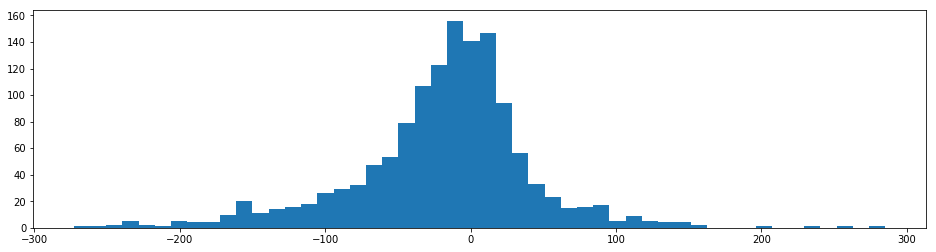

In [133]:
inv_error = inv_prediction - inv_actualsA[:]
inv_error_percent = inv_error / inv_actualsA[:]

#import numpy as np
#import matplotlib.mlab as mlab

mean = 100
sigma = 5

### data = np.random.normal(mean,sigma,1000) # generate fake data
#x = np.linspace(min(inv_error), max(inv_error), 100)

#plt.hist(inv_error, bins="auto",normed=True)
#plt.hist(inv_error, bins="auto",normed=False)
pyplot.figure(figsize=(16, 4))

#pyplot.hist(inv_error_percent, bins=50,normed=False)
pyplot.hist(inv_error, bins=50,normed=False)


#plt.plot(x, mlab.normpdf(x, mean, sigma))
pyplot.savefig('Model Runs History/' + 'histogram-' +  file_name  + '.pdf')
pyplot.show()

In [134]:
import scipy

scipy.stats.norm.interval(0.95, loc=mean, scale=sigma)

(90.20018007729973, 109.79981992270027)

In [135]:
test = abs(inv_error) < 33.0
test.sum() / 1328.0

0.5640060240963856

In [136]:
(abs(inv_actualsA[:] + 33.0)/inv_actualsA[:]).mean()

1.1977132054467603

In [137]:
inv_error = inv_prediction - inv_actualsA[:]
inv_error_percent = inv_error / inv_actualsA[:]

for i in range(1,40):
    test = (abs(inv_error_percent) < i/100.)
    if (test.sum() * 100.  / len(test)).round(2) >= 70:
        i -= 1
        break
    print( '% APE', i, '% count', (test.sum() * 100.  / len(test)).round(2))
print(i)

('% APE', 1, '% count', 2.98)
('% APE', 2, '% count', 6.11)
('% APE', 3, '% count', 9.4)
('% APE', 4, '% count', 12.53)
('% APE', 5, '% count', 16.55)
('% APE', 6, '% count', 19.61)
('% APE', 7, '% count', 23.27)
('% APE', 8, '% count', 26.17)
('% APE', 9, '% count', 29.01)
('% APE', 10, '% count', 31.17)
('% APE', 11, '% count', 33.86)
('% APE', 12, '% count', 36.76)
('% APE', 13, '% count', 39.9)
('% APE', 14, '% count', 42.95)
('% APE', 15, '% count', 46.53)
('% APE', 16, '% count', 48.92)
('% APE', 17, '% count', 51.68)
('% APE', 18, '% count', 53.99)
('% APE', 19, '% count', 56.67)
('% APE', 20, '% count', 59.06)
('% APE', 21, '% count', 61.15)
('% APE', 22, '% count', 63.68)
('% APE', 23, '% count', 65.77)
('% APE', 24, '% count', 67.56)
('% APE', 25, '% count', 69.87)
25


In [138]:
abs(inv_error_percent) < .1

array([False, False,  True, ..., False, False, False])

In [139]:
abs(inv_error_percent) < 0.02

array([False, False, False, ..., False, False, False])

In [140]:
for i in range(1,50):
    test = (abs(inv_error) < i)
    print( 'AE', i, '% count', (test.sum() * 100.  / len(test)).round(2))

('AE', 1, '% count', 1.79)
('AE', 2, '% count', 3.21)
('AE', 3, '% count', 5.22)
('AE', 4, '% count', 7.38)
('AE', 5, '% count', 9.84)
('AE', 6, '% count', 10.96)
('AE', 7, '% count', 13.35)
('AE', 8, '% count', 15.73)
('AE', 9, '% count', 17.45)
('AE', 10, '% count', 19.61)
('AE', 11, '% count', 21.85)
('AE', 12, '% count', 23.64)
('AE', 13, '% count', 25.95)
('AE', 14, '% count', 27.67)
('AE', 15, '% count', 29.98)
('AE', 16, '% count', 31.92)
('AE', 17, '% count', 33.48)
('AE', 18, '% count', 34.38)
('AE', 19, '% count', 36.39)
('AE', 20, '% count', 37.96)
('AE', 21, '% count', 39.6)
('AE', 22, '% count', 40.94)
('AE', 23, '% count', 42.73)
('AE', 24, '% count', 44.59)
('AE', 25, '% count', 45.71)
('AE', 26, '% count', 47.28)
('AE', 27, '% count', 48.25)
('AE', 28, '% count', 49.89)
('AE', 29, '% count', 51.6)
('AE', 30, '% count', 52.57)
('AE', 31, '% count', 53.69)
('AE', 32, '% count', 54.74)
('AE', 33, '% count', 55.85)
('AE', 34, '% count', 57.2)
('AE', 35, '% count', 58.17)
('